# BIMM 185 Lab Report 3
*Eric Mauritzen*



### Note about Week 2
The work completed on Tuesday (April 18) largely relied on the last weeks work so the old lab report was copied over as a starting point.  In the future I will be creating standalone functions from the code in this notebook.

## Introduction
This week we finished up the work on the codon usage index project by creating a few more plots.  We then went on to learn about `rsync` and downloaded 10 genomes from NCBI.  After that we used to biopython to parse the `.gbff` file from the E. Coli genome.  

    
## Functions Used

 - `rsync` : remote sync is used to copy data from a remote server.  After the first use, only the difference between the local and remote copies is downloaded.  
 
 - `Bio.SeqIO.parse` : This parsing function is capable of parsing several different types of files.  We used it this week to parse genbank `.gbff` and `.fasta` files.  
 
 - `gzip` : The gzip library allows for compressed files to be read without decompressing them on the disk.
 
 - `pandas` : As with previous assignments, I use the `pandas` library to handle collections of heterogenous data.  


## Conclusions

From the work Tuesday I learned about the `rsync` command.  I was entirely unaware of it but look forward to using it in the future.  Beyond the applications we saw from lab it would be great for period backups of folders or entire drives.

From Thursday I learned about using the Biopython parser.  It was certainly useful but is not intuitive or well documented.  This makes it exceedingly hard to use in practice.  I also learned about some of the fields in the genbank file that we were loading.  I was not familiar with the EC-number before class but now understand it relates to enzyme efficiency.  


In [1]:
import pandas as pd
import numpy as np
import os
import platform
df = pd.read_table('data/ProteinTable.txt')

### Tabular Annotations (Exercise 3)

Generate a fasta file from the E. Colo genome and the annotations table.

There should be an entry in the fasta file for every row in the table.


In [2]:
# Read in the E. Coli genome
import textwrap
from Bio.Seq import Seq
from Bio.Alphabet import generic_dna

with open('data/EColi.fna') as f:
    # Open the genome
    ecoli = f.read()

In [3]:
# Make it one string
ecoli_genome = ''.join(ecoli.splitlines()[1:])

## WEEK 2 | Thursday, April 13

Implement the Codon-Usage-Index 

### Part 1: Modify the old FASTA file to make the sequence one line per gene

In [4]:
# Read in the E. Coli genome
import textwrap
from Bio.Seq import Seq
from Bio.Alphabet import generic_dna

with open('data/EColi.fna') as f:
    # Open the genome
    ecoli = f.read()
    
# Make it one string
ecoli_genome = ''.join(ecoli.splitlines()[1:])

# Loop over every row of the table
out_str = ''
for ind, entry in df.iterrows():
    s = entry['Start']
    e = entry['Stop']
    strand = Seq(ecoli_genome[s-1:e], generic_dna)
    out_str += entry['Locus tag']
    out_str += '\t'
    if entry['Strand'] == ('+'):
        out_str += str(strand)
    else:
        out_str += str(strand.reverse_complement())
            
    out_str += '\n'
    
# Print just the beginning
print(out_str[0:1000])

# Write to file
with open('OutputFiles/OutFile_SingleLine.faa', 'w') as f:
    f.write(out_str)

b0001	ATGAAACGCATTAGCACCACCATTACCACCACCATCACCATTACCACAGGTAACGGTGCGGGCTGA
b0002	ATGCGAGTGTTGAAGTTCGGCGGTACATCAGTGGCAAATGCAGAACGTTTTCTGCGTGTTGCCGATATTCTGGAAAGCAATGCCAGGCAGGGGCAGGTGGCCACCGTCCTCTCTGCCCCCGCCAAAATCACCAACCACCTGGTGGCGATGATTGAAAAAACCATTAGCGGCCAGGATGCTTTACCCAATATCAGCGATGCCGAACGTATTTTTGCCGAACTTTTGACGGGACTCGCCGCCGCCCAGCCGGGGTTCCCGCTGGCGCAATTGAAAACTTTCGTCGATCAGGAATTTGCCCAAATAAAACATGTCCTGCATGGCATTAGTTTGTTGGGGCAGTGCCCGGATAGCATCAACGCTGCGCTGATTTGCCGTGGCGAGAAAATGTCGATCGCCATTATGGCCGGCGTATTAGAAGCGCGCGGTCACAACGTTACTGTTATCGATCCGGTCGAAAAACTGCTGGCAGTGGGGCATTACCTCGAATCTACCGTCGATATTGCTGAGTCCACCCGCCGTATTGCGGCAAGCCGCATTCCGGCTGATCACATGGTGCTGATGGCAGGTTTCACCGCCGGTAATGAAAAAGGCGAACTGGTGGTGCTTGGACGCAACGGTTCCGACTACTCTGCTGCGGTGCTGGCTGCCTGTTTACGCGCCGATTGTTGCGAGATTTGGACGGACGTTGACGGGGTCTATACCTGCGACCCGCGTCAGGTGCCCGATGCGAGGTTGTTGAAGTCGATGTCCTACCAGGAAGCGATGGAGCTTTCCTACTTCGGCGCTAAAGTTCTTCACCCCCGCACCATTACCCCCATCGCCCAGTTCCAGATCCCTTGCCTGATTAAAAATACCGGAAATCCTCAAGCACCAGGTACGCTCATTGGTGCCAGCCGTGATGAAGACGAATTACCGGTCAAG

### Part 2: Create a function to calculate normalized codon frequencies
We use the following equations to model codon usage
![title](relative_freq.png)

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
gene_table = pd.read_table('OutputFiles/OutFile_SingleLine.faa', names=['gene', 'seq'])

In [6]:
from collections import Counter

codons = textwrap.fill(ecoli_genome.strip()[:10000], 3).splitlines()
codons = set([codon for codon in codons if len(codon) == 3])
base_dict = {codon :0 for codon in codons}
for codon in codons:
    gene_table[codon] = 0

for ind, entry in gene_table.iterrows():
    codons_here = textwrap.fill(entry['seq'],3).splitlines()
    for codon, codon_count in zip(Counter(codons_here).keys(), Counter(codons_here).values()):
        if codon in gene_table.columns:
            gene_table.set_value(ind, codon, codon_count)
        else:
            print('Warning')
            print('Gene: ' + entry['gene'])
                


Warning
Gene: b2891


In [7]:
# Make a copy of the original table.
# The new table will be used for calculating 
Counts_DF = gene_table.copy()
del Counts_DF['seq']
Counts_DF = Counts_DF.set_index('gene')

Here we finalize the codon usage index values with the following equation
![title](CUI.png) 

In [8]:
# Create the Normalized Count Table
totals = Counts_DF.sum()
normalized_totals = totals / sum(totals)
Norm_Counts = Counts_DF.div(Counts_DF.sum(axis=1), axis=0)

# Populate table
Norm_Counts['CUI'] = 0.0
for ind, entry in Norm_Counts.iterrows():
    val = (Norm_Counts.ix[ind] * normalized_totals).sum()
    Norm_Counts.set_value(ind, 'CUI', val)

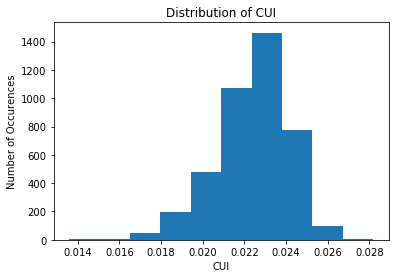

In [9]:
# Plot the distribution of CUI values
plt.hist(list(Norm_Counts['CUI']))
plt.xlabel('CUI')
plt.ylabel('Number of Occurences')
plt.title('Distribution of CUI')

### Below we will look for statistical differences between the ribosomal and non-ribosomal proteins.

The ribosomal proteins have a mean CUI of 0.0232 while the non-ribosomal proteins have a CUI of 0.0224.

We'll use a box-and-whisker plot to visualize the distributions side-by-side.


In [10]:
# Put the CUI values into the gene table and select a subset of this table
gene_table['CUI'] = Norm_Counts['CUI']
df2 = df.set_index('Locus tag').join(Norm_Counts[['CUI']])[['Locus', 'Protein name', 'CUI', 'Start']]

In [11]:
# Plot the statistics for the ribosomal proteins
df2.loc[df2['Protein name'].str.contains('ribosomal')]['CUI'].describe()

count    66.000000
mean      0.023201
std       0.001323
min       0.018761
25%       0.022569
50%       0.023277
75%       0.024085
max       0.025576
Name: CUI, dtype: float64

In [12]:
# Plot the statistics for the non-ribosomal proteins
df2.loc[~df2['Protein name'].str.contains('ribosomal')]['CUI'].describe()

count    4074.000000
mean        0.022396
std         0.001727
min         0.013575
25%         0.021451
50%         0.022586
75%         0.023615
max         0.028185
Name: CUI, dtype: float64

<center><h1> WEEK 3 Tuesday

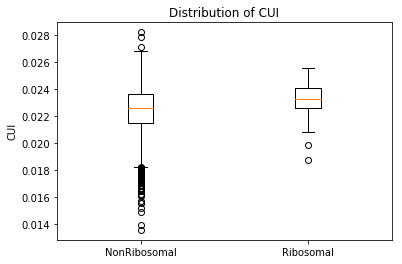

In [13]:
# Create series from the two groups
y = list(df2.loc[df2['Protein name'].str.contains('ribosomal')]['CUI'])
x = list(df2.loc[~df2['Protein name'].str.contains('ribosomal')]['CUI'])

# Plot the Box and Whisker Plot
plt.boxplot([x, y], labels=['NonRibosomal', 'Ribosomal'])
plt.ylabel('CUI')
plt.title('Distribution of CUI')
plt.show()

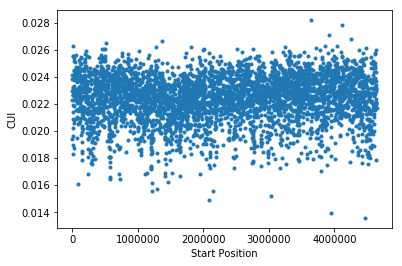

In [14]:
plt.plot(list(df2['Start']), list(df2['CUI']), '.')
plt.xlabel('Start Position')
plt.ylabel('CUI')

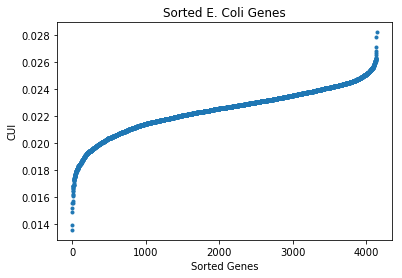

In [15]:
CUI_list = list(df2['CUI'])
CUI_list.sort()
plt.plot(CUI_list, '.')
plt.ylabel('CUI')
plt.xlabel('Sorted Genes')
plt.title('Sorted E. Coli Genes')

In [2]:
euk = pd.read_table('data/ASSEMBLY_REPORTS/assembly_summary_refseq.txt', header=1, low_memory=False)

In [3]:
euk[['organism_name', 'taxid', 'ftp_path']]

,organism_name,taxid,ftp_path
0,Drosophila melanogaster,7227,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000...
1,Homo sapiens,9606,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000...
2,Pan troglodytes,9598,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000...
3,Pongo abelii,9601,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000...
4,Mus musculus,10090,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000...
5,Arabidopsis thaliana,3702,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000...
6,Drosophila pseudoobscura pseudoobscura,46245,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000...
7,Rattus norvegicus,10116,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000...
8,Loxodonta africana,9785,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000...
9,Talaromyces marneffei ATCC 18224,441960,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000...


In [57]:
from subprocess import call

# An example path
for i in range(10):
    ftp_str = euk.loc[i]['ftp_path']
    rsync_str = ftp_str.replace('ftp', 'rsync')
    command_str = 'rsync -avz ' + rsync_str + ' ' + str(euk.loc[i]['organism_name']).replace(' ', '_')
    call(["rsync", "-avz", rsync_str, 'data/Genomes/' + str(euk.loc[i]['organism_name']).replace(' ', '_')])
    
for taxid in [511145, 1435057]:
    ftp_str = euk[euk['taxid'] == taxid].iloc[0].ftp_path
    organism_name = euk[euk['taxid'] == taxid].iloc[0].organism_name
    rsync_str = ftp_str.replace('ftp', 'rsync')
    command_str = 'rsync -avz ' + rsync_str + ' ' + str(organism_name).replace(' ', '_')
    call(["rsync", "-avz", rsync_str, 'data/Genomes/' + str(organism_name).replace(' ', '_')])

# Week 3 Thursday
## Exercise 1

In [18]:
import gzip

In [135]:
from Bio import SeqIO
for seq_record in SeqIO.parse("data/E_coli_K12/GCF_000005845.2_ASM584v2_genomic.gbff", "genbank"):
    print(seq_record.id)
    print(repr(seq_record.seq))
    print(len(seq_record))

NC_000913.3
Seq('AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTGTGGATTAAAAAAAG...TTC', IUPACAmbiguousDNA())
4641652


In [138]:
with open('OutputFiles/Wk3Th.txt', 'w') as f:
    tax_id = seq_record.features[0].qualifiers['db_xref'][0].split(':')[-1]
    for gene in seq_record.features:
        if not gene.type == 'CDS':
            continue
        if 'protein_id' not in gene.qualifiers.keys():
            protein_id = 'psuedo'
            protein_name = 'pseudo'
        else:
            protein_id = str(gene.qualifiers['protein_id']).replace("'", '').replace('[', '').replace(']', '')
            protein_name = str(gene.qualifiers['product']).replace("'", '').replace('[', '').replace(']', '')
            
        coordinates_start = gene.location.start
        coordinates_end = gene.location.end
        strand = gene.location.strand
        gene_name = str(gene.qualifiers['gene']).replace("'", '').replace('[', '').replace(']', '')
        locus_tag = str(gene.qualifiers['locus_tag']).replace("'", '').replace('[', '').replace(']', '')
        synonyms = str(gene.qualifiers['gene_synonym']).replace("'", '').replace('[', '').replace(']', '')
        
        tax_id = tax_id
        ext_ref = str(gene.qualifiers['db_xref']).replace("'", '').replace('[', '').replace(']', '')
        ec_number = '-'
        if 'EC_number' in gene.qualifiers.keys():
            ec_number = str(gene.qualifiers['EC_number']).replace("'", '').replace('[', '').replace(']', '')
        st = ('%s\t%d\t%d\t%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\n' % (protein_id, coordinates_start, coordinates_end, strand, gene_name, locus_tag, synonyms, protein_name, tax_id, ec_number, ext_ref))
        f.write(st)

In [116]:
cols=['protein_id', 'coordinates_start', 'coordinates_end', 'strand', 'gene_name', 'locus_tag', 'synonyms', 'protein_name', 'tax_id', 'ec_number', 'ext_ref']
ecoli_df = pd.read_table('Wk3Th.txt', index_col=False, names=cols)
ecoli_df

,protein_id,coordinates_start,coordinates_end,strand,gene_name,locus_tag,synonyms,protein_name,tax_id,ec_number,ext_ref
0,NP_414542.1,189,255,1,thrL,b0001,ECK0001; JW4367,thr operon leader peptide,511145,-,"['GI:16127995', 'ASAP:ABE-0000006', 'UniProtKB..."
1,NP_414543.1,336,2799,1,thrA,b0002,ECK0002; Hs; JW0001; thrA1; thrA2; thrD,Bifunctional aspartokinase/homoserine dehydrog...,511145,"['1.1.1.3', '2.7.2.4']","['GI:16127996', 'ASAP:ABE-0000008', 'UniProtKB..."
2,NP_414544.1,2800,3733,1,thrB,b0003,ECK0003; JW0002,homoserine kinase,511145,['2.7.1.39'],"['GI:16127997', 'ASAP:ABE-0000010', 'UniProtKB..."
3,NP_414545.1,3733,5020,1,thrC,b0004,ECK0004; JW0003,L-threonine synthase,511145,['4.2.3.1'],"['GI:16127998', 'ASAP:ABE-0000012', 'UniProtKB..."
4,NP_414546.1,5233,5530,1,yaaX,b0005,ECK0005; JW0004,DUF2502 family putative periplasmic protein,511145,-,"['GI:16127999', 'ASAP:ABE-0000015', 'UniProtKB..."
5,NP_414547.1,5682,6459,-1,yaaA,b0006,ECK0006; JW0005,"peroxide resistance protein, lowers intracellu...",511145,-,"['GI:16128000', 'ASAP:ABE-0000018', 'UniProtKB..."
6,NP_414548.1,6528,7959,-1,yaaJ,b0007,ECK0007; JW0006,putative transporter,511145,-,"['GI:16128001', 'ASAP:ABE-0000020', 'UniProtKB..."
7,NP_414549.1,8237,9191,1,talB,b0008,ECK0008; JW0007; yaaK,transaldolase B,511145,['2.2.1.2'],"['GI:16128002', 'ASAP:ABE-0000027', 'UniProtKB..."
8,NP_414550.1,9305,9893,1,mog,b0009,bisD; chlG; ECK0009; JW0008; mogA; yaaG,molybdochelatase incorporating molybdenum into...,511145,-,"['GI:16128003', 'ASAP:ABE-0000030', 'UniProtKB..."
9,NP_414551.1,9927,10494,-1,satP,b0010,ECK0010; JW0009; yaaH,succinate-acetate transporter,511145,-,"['GI:16128004', 'ASAP:ABE-0000032', 'UniProtKB..."


## Exercise 2

In [150]:
with open('OutputFiles/Wk3ThEx2.txt', 'w') as f:
    for seq_record in SeqIO.parse("data/E_coli_K12/GCF_000005845.2_ASM584v2_protein.faa", "fasta"):
        f.write('%s\t%s\n' % (seq_record.id, seq_record.seq))

## Exercise 3

In [55]:
# Download README
import os 
if not platform.system() == 'Windows':
    os.system('wget -O data/ProteinReadme.txt ftp://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/reference_proteomes/README')


In [53]:
# Select protein IDs
import re
with open('data/ProteinReadme.txt') as f:
    ProteinTxt = f.read()
ALLIDS = re.findall('(UP\d+)', ProteinTxt)
ProteomeIDs = ALLIDS[:5]

In [54]:
# download genomic files
for ID in ProteomeIDs:
    if not platform.system() == 'Windows':
        os.system('wget -nc -P data/%s ftp://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/reference_proteomes/Bacteria/%s_*' % (ID, ID))

## Exercise 4

In [4]:
from Bio.SeqIO.UniprotIO import Parser
import Bio.SeqIO
from Bio import SeqIO
from Bio import SwissProt

In [61]:
d = SeqIO.parse('data/uniprot_sprot_archaea.dat', 'swiss')
df = pd.DataFrame(columns=['tax_id','organism','taxonomy'])
for i, feature in enumerate(d):
    
    taxid = feature.annotations['ncbi_taxid'][0]
    og = feature.annotations['organism']
    tax = str(feature.annotations['taxonomy'])
    tax = tax.replace('[', '').replace(']', '').replace("'", '')
    
    df.loc[i] = [taxid, og, tax]
    


In [62]:
df = df.drop_duplicates('tax_id')
df.to_csv('Ex4.tsv', sep='\t', index=False)

In [51]:
sub = euk[ euk['taxid']  == 511145]

In [22]:
sub = sub[['ftp_path']]

In [29]:
pd.set_option('display.width', 1000)

In [54]:
st = sub.iloc[0]

In [52]:
st = str(sub.iloc[0])


In [56]:
st

# assembly_accession                                           GCF_000005845.2
bioproject                                                          PRJNA57779
biosample                                                         SAMN02604091
wgs_master                                                                 NaN
refseq_category                                               reference genome
taxid                                                                   511145
species_taxid                                                              562
organism_name                        Escherichia coli str. K-12 substr. MG1655
infraspecific_name                                  strain=K-12 substr. MG1655
isolate                                                                    NaN
version_status                                                          latest
assembly_level                                                 Complete Genome
release_type                                        

In [48]:
euk[euk['taxid'] == 1435057].iloc[0].ftp_path

'ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/576/515/GCF_000576515.1_ASM57651v1'